In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import pathlib
from nltk.stem.lancaster import LancasterStemmer
from pathlib import Path

# Set some parameters in the packages 

plt.rcParams['figure.figsize'] = (10,7)
pd.options.display.max_rows = 20  
pd.options.display.max_columns = 15

# Some packages to help with configuration

import os, sys, watermark

print("python", sys.version.split("|")[0], "\n")

assert 'pandas' in sys.modules and "pd" in locals()
print(watermark.watermark(packages = "pandas"))

assert 'numpy' in sys.modules and "np" in locals()
print(watermark.watermark(packages = "numpy"))

assert 'matplotlib' in sys.modules and "plt" in locals()
print(watermark.watermark(packages = "matplotlib"))

assert 're' in sys.modules and 'pathlib' in sys.modules
print(watermark.watermark(packages = "re"))

python 3.11.11  

pandas: 2.2.3

numpy: 2.0.2

matplotlib: 3.10.0

re: 2.2.1



In [99]:
authors_path = "authors.csv"

authors = pd.read_csv(authors_path)
authors

authors = authors.drop(index = [4])
authors

,author,number
0,jay,"[2, 3, 4, 5, 64]"
1,madison,"[10, 14, 18, 19, 20, 37, 38, 39, 40, 41, 42, 4..."
2,hamilton,"[1, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 21, 22..."
3,hamilton+madison,"[18, 19, 20]"


In [100]:
authors["frequency"] = authors["number"].apply(lambda entry: len(entry.split(",")))
authors

,author,number,frequency
0,jay,"[2, 3, 4, 5, 64]",5
1,madison,"[10, 14, 18, 19, 20, 37, 38, 39, 40, 41, 42, 4...",17
2,hamilton,"[1, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 21, 22...",51
3,hamilton+madison,"[18, 19, 20]",3


In [101]:
authors["frequency"] += [0, 1.5, 1.5, -3]
authors = authors.drop(index = [3])
authors 

,author,number,frequency
0,jay,"[2, 3, 4, 5, 64]",5.0
1,madison,"[10, 14, 18, 19, 20, 37, 38, 39, 40, 41, 42, 4...",18.5
2,hamilton,"[1, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 21, 22...",52.5


In [102]:
total = authors["frequency"].sum()
authors["relative frequency"] = authors["frequency"] / total
authors

,author,number,frequency,relative frequency
0,jay,"[2, 3, 4, 5, 64]",5.0,0.065789
1,madison,"[10, 14, 18, 19, 20, 37, 38, 39, 40, 41, 42, 4...",18.5,0.243421
2,hamilton,"[1, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 21, 22...",52.5,0.690789


In [103]:
prior_probability = authors[["author","relative frequency"]].set_index("author").to_dict()["relative frequency"]
prior_probability 

{'jay': 0.06578947368421052,
 'madison': 0.24342105263157895,
 'hamilton': 0.6907894736842105}

In [104]:
def convert_to_lowercase(text):
    if not isinstance(text, str):
        raise ValueError("Input must be a string")
    
    return text.lower()

In [105]:
regular_expression_pattern = r"\w+"

In [106]:
stop_words_path = "stop_words.csv"

In [107]:
stop_words = pd.read_csv(stop_words_path)
stop_words 

,Stop Words
0,mightn't
1,about
2,wouldn't
3,can
4,you'll
...,...
176,at
177,more
178,below
179,until


In [108]:
stop_words = stop_words["Stop Words"].values

def filter_stop_words(series):
    return series[~series.isin(stop_words)]

In [109]:
stemming = LancasterStemmer()

In [110]:
society_stemmed = stemming.stem("society")
print(society_stemmed)

socy


In [111]:
def process_text(text): 
    text = convert_to_lowercase(text)
    
    text = re.findall(regular_expression_pattern, text)
    
    series = pd.Series(text)
    
    series = filter_stop_words(series)
    
    # convert words to stemmed words 
    series = series.apply(lambda word: stemming.stem(word))
   
    
    return series

In [112]:
from pathlib import Path

jay_folder = Path("jay")
madison_folder = Path("madison")
hamilton_folder = Path("hamilton")
disputed_folder = Path("disputed")

In [113]:
for file in jay_folder.glob("*"):
    print(file)

jay/federalist_2.txt
jay/federalist_4.txt
jay/federalist_64.txt
jay/federalist_5.txt
jay/federalist_3.txt


In [114]:
essay_text = []
for file in jay_folder.glob("*"):
    with open(file, "r", encoding='latin-1') as file_handle:
        essay_text.append(process_text(file_handle.read()))

In [115]:
essay_text_full = pd.concat(essay_text)
essay_text_full

2         peopl
5          stat
7           new
8          york
11        peopl
         ...   
1439       humy
1441      spain
1443    britain
1447        pow
1448        nat
Length: 3919, dtype: object

In [116]:
likelihood_probability_jay = essay_text_full.value_counts()
likelihood_probability_jay = likelihood_probability_jay / likelihood_probability_jay.sum()
likelihood_probability_jay

nat          0.020924
govern       0.014289
peopl        0.012248
on           0.011993
stat         0.009952
               ...   
jurisdict    0.000255
temp         0.000255
few          0.000255
app          0.000255
irrit        0.000255
Name: count, Length: 1118, dtype: float64

In [117]:
likelihood_probability = dict.fromkeys(["jay", "hamilton", "madison"])
likelihood_probability

{'jay': None, 'hamilton': None, 'madison': None}

In [118]:
likelihood_probability["jay"] = likelihood_probability_jay

In [119]:
# Process the Hamilton folder
essay_text_hamilton = []
for file in hamilton_folder.glob("*"):
    with open(file, "r", encoding="latin-1") as file_handle:
        essay_text_hamilton.append(process_text(file_handle.read()))

# Combine all words from Hamilton essays into a single series
essay_text_full_hamilton = pd.concat(essay_text_hamilton)
essay_text_full_hamilton
likelihood_probability_hamilton = essay_text_full_hamilton.value_counts()
likelihood_probability_hamilton = likelihood_probability_hamilton / likelihood_probability_hamilton.sum()
likelihood_probability_hamilton

# Process the Madison folder
essay_text_madison = []
for file in madison_folder.glob("*"):
    with open(file, "r", encoding="latin-1") as file_handle:
        essay_text_madison.append(process_text(file_handle.read()))

# Combine all words from Madison essays into a single series
essay_text_full_madison = pd.concat(essay_text_madison)
essay_text_full_madison
likelihood_probability_madison = essay_text_full_madison.value_counts()
likelihood_probability_madison = likelihood_probability_madison / likelihood_probability_madison.sum()
likelihood_probability_madison

# Update the dictionary
likelihood_probability["hamilton"] = likelihood_probability_hamilton
likelihood_probability["madison"] = likelihood_probability_madison

# Format the output for better readability
for author, probabilities in likelihood_probability.items():
    print(f"\nRelative word frequencies for {author.capitalize()}:\n")
    print(probabilities.sort_values(ascending=False).head(10))  # Display the top 10 most common words



Relative word frequencies for Jay:

nat         0.020924
govern      0.014289
peopl       0.012248
on          0.011993
stat        0.009952
may         0.008676
us          0.008676
treaty      0.008421
form        0.007400
interest    0.007400
Name: count, dtype: float64

Relative word frequencies for Hamilton:

stat         0.019321
govern       0.010887
nat          0.010588
pow          0.010428
may          0.009272
upon         0.007417
constitut    0.007178
on           0.005703
peopl        0.005364
must         0.005264
Name: count, dtype: float64

Relative word frequencies for Madison:

stat         0.020475
govern       0.015025
pow          0.014200
constitut    0.009803
may          0.009345
legisl       0.007146
form         0.007054
peopl        0.006871
on           0.006871
nat          0.006642
Name: count, dtype: float64


In [120]:
most_common_hamilton = likelihood_probability["hamilton"].idxmax()
print(f"The most common word in Hamilton's essays is: {most_common_hamilton}")

#most common word for Madison
most_common_madison = likelihood_probability["madison"].idxmax()
print(f"The most common word in Madison's essays is: {most_common_madison}")

q3 = most_common_hamilton == most_common_madison
print(f"Are they the same? {'True' if q3 else 'False'}")

The most common word in Hamilton's essays is: stat
The most common word in Madison's essays is: stat
Are they the same? True


In [121]:
common_words = np.array(['upon', 'us', 'form', 'constitut', 'stat', 'un', 'pow', 'peopl','legisl', 'treaty', 'on', 'interest', 'may', 'govern', 'nat'])
common_words

array(['upon', 'us', 'form', 'constitut', 'stat', 'un', 'pow', 'peopl',
       'legisl', 'treaty', 'on', 'interest', 'may', 'govern', 'nat'],
      dtype='<U9')

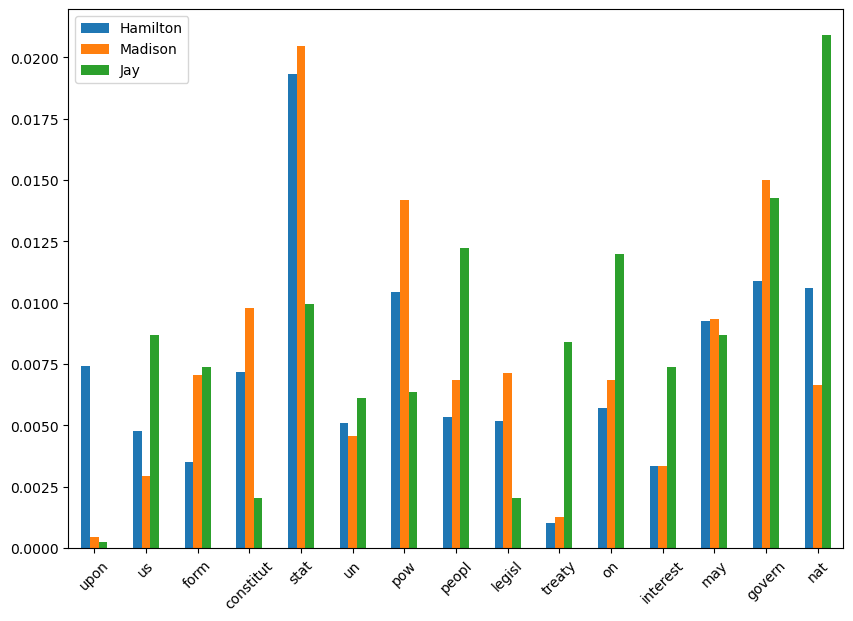

In [122]:
barchart_data = pd.merge(left = likelihood_probability["hamilton"][common_words].to_frame("Hamilton"), 
                         right = likelihood_probability["madison"][common_words].to_frame("Madison"), 
                         left_index = True, 
                         right_index = True)

barchart_data = pd.merge(left = barchart_data, 
                         right = likelihood_probability["jay"][common_words].to_frame("Jay"), 
                         left_index = True, 
                         right_index = True)

barchart_data.plot(kind = "bar", rot = 45);

In [123]:
prior_probability["jay"]

0.06578947368421052

In [124]:
likelihood_probability["jay"].to_dict()

{'nat': 0.020923705026792548,
 'govern': 0.014289359530492473,
 'peopl': 0.012248022454707833,
 'on': 0.011992855320234754,
 'stat': 0.009951518244450114,
 'may': 0.008675682572084715,
 'us': 0.008675682572084715,
 'treaty': 0.008420515437611636,
 'interest': 0.007399846899719316,
 'form': 0.007399846899719316,
 'men': 0.006634345496300076,
 'wel': 0.006379178361826996,
 'consid': 0.006379178361826996,
 'pow': 0.006379178361826996,
 'un': 0.0061240112273539165,
 'conf': 0.005868844092880837,
 'gre': 0.005868844092880837,
 'war': 0.005868844092880837,
 'americ': 0.005868844092880837,
 'giv': 0.005613676958407757,
 'mak': 0.0053585098239346774,
 'adv': 0.0051033426894615975,
 'foreign': 0.004337841286042358,
 'good': 0.004337841286042358,
 'conv': 0.004337841286042358,
 'sen': 0.004082674151569278,
 'respect': 0.004082674151569278,
 'caus': 0.004082674151569278,
 'country': 0.003827507017096198,
 'many': 0.003827507017096198,
 'object': 0.003827507017096198,
 'circumst': 0.00357233988262

In [125]:
def calculate_likelihood(processed_text, likelihood, default = 0.000001):
    processed_text_with_probability = processed_text.apply(lambda entry: likelihood.get(entry, default))
    return np.prod(processed_text_with_probability)

In [126]:
def calculate_posterior(processed_text, prior, likelihood, names = ["jay", "hamilton", "madison"]):
    output = dict()
    for name in names: 
        name_likelihood = calculate_likelihood(processed_text, likelihood[name], default=0.00001)
        name_prior = prior[name]
        output[name] = name_likelihood * name_prior
    return output 

In [127]:
jay_essays_text = dict()
for file in jay_folder.glob("*"):
    with open(file, "r") as file_handle:
        jay_essays_text[file.stem] = file_handle.read()

In [128]:
for title, text in jay_essays_text.items():
    text_processed = process_text(text)
    posterior_probability = calculate_posterior(text_processed[50:100], prior_probability, likelihood_probability)
    print("Essay:",title," Guess:", max(posterior_probability.keys(), key=lambda entry: posterior_probability[entry]))

Essay: federalist_2  Guess: jay
Essay: federalist_4  Guess: jay
Essay: federalist_64  Guess: jay
Essay: federalist_5  Guess: jay
Essay: federalist_3  Guess: jay


In [129]:
q5_1 = 0
# Define the Madison essays text dictionary
madison_essays_text = dict()

# Populate the dictionary with essay texts
for file in madison_folder.glob("*"):  # Replace `madison_folder` with the actual path variable
    with open(file, "r", encoding="latin-1") as file_handle:
        madison_essays_text[file.stem] = file_handle.read()

for title, text in madison_essays_text.items():
    # Process the text using the process_text function
    text_processed = process_text(text)
    
    # Calculate posterior probabilities using the descriptive model
    posterior_probability = calculate_posterior(
        text_processed[50:100],  # Use words 50 to 100
        prior_probability,
        likelihood_probability
    )
    
    # Guess the most likely author
    guessed_author = max(posterior_probability.keys(), key=lambda entry: posterior_probability[entry])
    
    # Check if the guessed author is James Madison
    if guessed_author == "madison":
        q5_1 += 1

# Print the result
print(f"The descriptive model correctly guesses James Madison for {q5_1} essays.")

The descriptive model correctly guesses James Madison for 17 essays.


In [130]:
disputed_essay_authors = dict().fromkeys(["federalist_{}".format(number) for number in [49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 62, 63]])
disputed_essay_authors

{'federalist_49': None,
 'federalist_50': None,
 'federalist_51': None,
 'federalist_52': None,
 'federalist_53': None,
 'federalist_54': None,
 'federalist_55': None,
 'federalist_56': None,
 'federalist_57': None,
 'federalist_58': None,
 'federalist_62': None,
 'federalist_63': None}

In [131]:
disputed_essays_text = dict()
for file in disputed_folder.glob("*"):
    with open(file, "r") as file_handle:
        disputed_essays_text[file.stem] = file_handle.read()

In [132]:
# Populate the disputed_essay_authors dictionary with guesses
for title, text in disputed_essays_text.items():
    # Process the text using the process_text function
    text_processed = process_text(text)
    
    # Calculate posterior probabilities using the descriptive model
    posterior_probability = calculate_posterior(
        text_processed[50:100],  # Use words 50 to 100
        prior_probability,
        likelihood_probability
    )
    
    # Guess the most likely author
    guessed_author = max(posterior_probability.keys(), key=lambda entry: posterior_probability[entry])
    
    # Update the dictionary with the guessed author
    disputed_essay_authors[title] = guessed_author

# Print the result for verification
print("Disputed Essay Authors:")
for title, author in disputed_essay_authors.items():
    print(f"Essay: {title}, Guessed Author: {author}")



Disputed Essay Authors:
Essay: federalist_49, Guessed Author: madison
Essay: federalist_50, Guessed Author: hamilton
Essay: federalist_51, Guessed Author: madison
Essay: federalist_52, Guessed Author: hamilton
Essay: federalist_53, Guessed Author: hamilton
Essay: federalist_54, Guessed Author: hamilton
Essay: federalist_55, Guessed Author: hamilton
Essay: federalist_56, Guessed Author: madison
Essay: federalist_57, Guessed Author: madison
Essay: federalist_58, Guessed Author: madison
Essay: federalist_62, Guessed Author: madison
Essay: federalist_63, Guessed Author: hamilton
